## Model with 15 dimensions in latent space

In [1]:
import scanpy as sc
import scvi
import numpy as np

Global seed set to 0


In [2]:
adata = scvi.data.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/anndata_rna.h5ad")

In [3]:
sc.pp.filter_genes(adata, min_counts=3)

In [4]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`
adata.raw

In [5]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample"
)

In [6]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["sample"],
    continuous_covariate_keys=["mitochondrial_percent_RNA", "ribosomal_percent_RNA"]
)

/omics/groups/OE0533/internal/katharina/scvi2/lib/python3.7/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


In [7]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    
    dropout_rate=0.2,
    n_layers=2,n_latent=20,gene_likelihood='nb'
)

model = scvi.model.SCVI(
    adata,
    **arches_params
)

In [8]:
#model.train()

In [62]:
# load anndata with latent space
adata = scvi.data.read_h5ad("gpu_trained_15_dim/anndata_object")

In [63]:
adata

AnnData object with n_obs × n_vars = 45991 × 5000
    obs: 'sample', 'stage', 'nFeature_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA', 'celltype', '_scvi_batch', '_scvi_labels'
    var: 'gene', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs'
    layers: 'counts'

In [64]:
# load trained model
model = scvi.model.SCVI.load("gpu_trained_15_dim/", adata=adata, use_gpu=False)

/omics/groups/OE0533/internal/katharina/scvi2/lib/python3.7/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


In [65]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: nb, latent_distribution: normal
Training status: Trained

In [66]:
latent = model.get_latent_representation()

In [67]:
latent

array([[-0.91806316, -0.12784117,  0.23160481, ...,  0.28449017,
         0.681568  , -1.5206331 ],
       [-1.0148311 , -1.5290767 ,  0.16302168, ...,  0.47000292,
         0.7854357 ,  1.2828212 ],
       [-0.334761  , -1.0004845 , -0.30817246, ...,  0.31447038,
         0.15872781, -0.7215703 ],
       ...,
       [ 0.36089864, -0.45519853,  1.9123824 , ...,  1.5186572 ,
        -1.3554718 ,  0.00795566],
       [-1.955086  , -0.19193381,  0.4403254 , ..., -1.7333434 ,
        -0.16778393,  1.0884081 ],
       [ 0.4992277 , -0.11916548, -0.9221376 , ...,  0.1960333 ,
        -0.35230654, -0.1923731 ]], dtype=float32)

In [68]:
adata

AnnData object with n_obs × n_vars = 45991 × 5000
    obs: 'sample', 'stage', 'nFeature_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA', 'celltype', '_scvi_batch', '_scvi_labels'
    var: 'gene', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs'
    layers: 'counts'

## Visualization without batch correction

In [69]:
sc.set_figure_params(figsize=(8,8))

In [78]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.1)

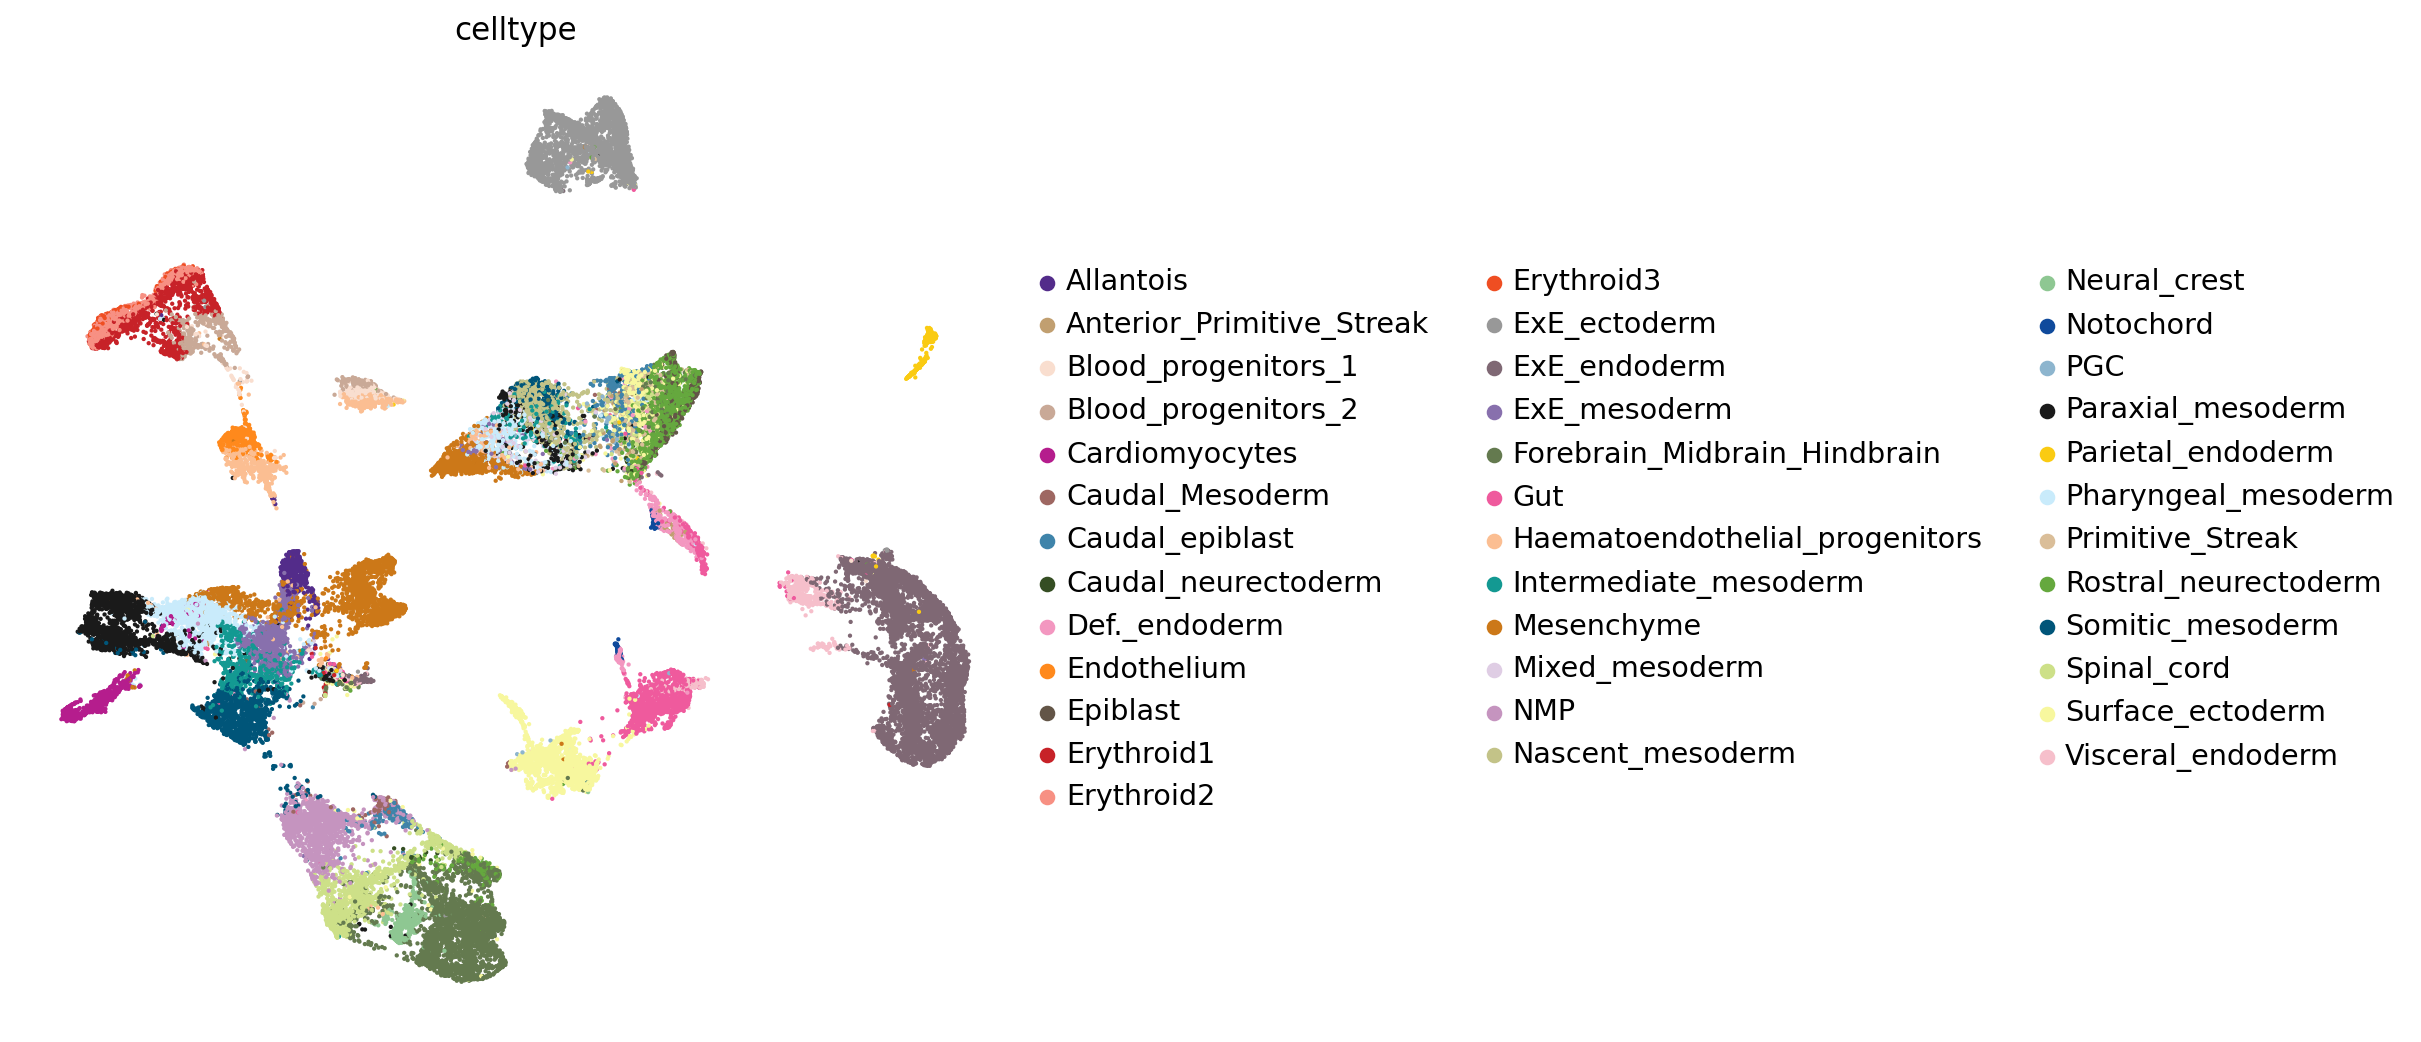

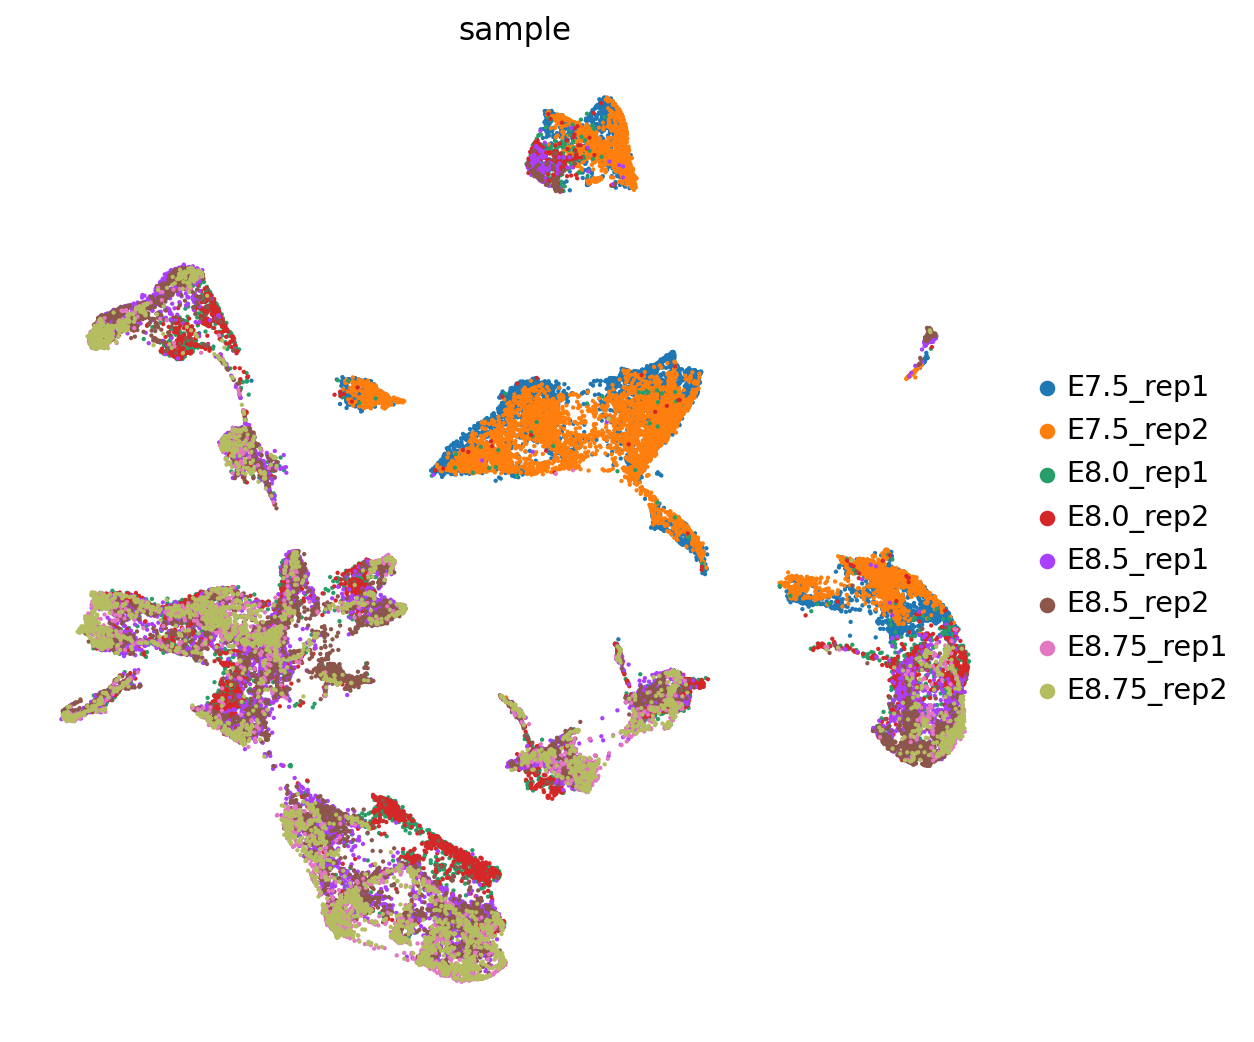

In [79]:
sc.pl.umap(
    adata,
    color=["celltype"],
    frameon=False,
    size=15
)
sc.pl.umap(
    adata,
    color=["sample"],
    ncols=2,
    frameon=False,
    size=15
)

## Visualization with batch correction 

In [72]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

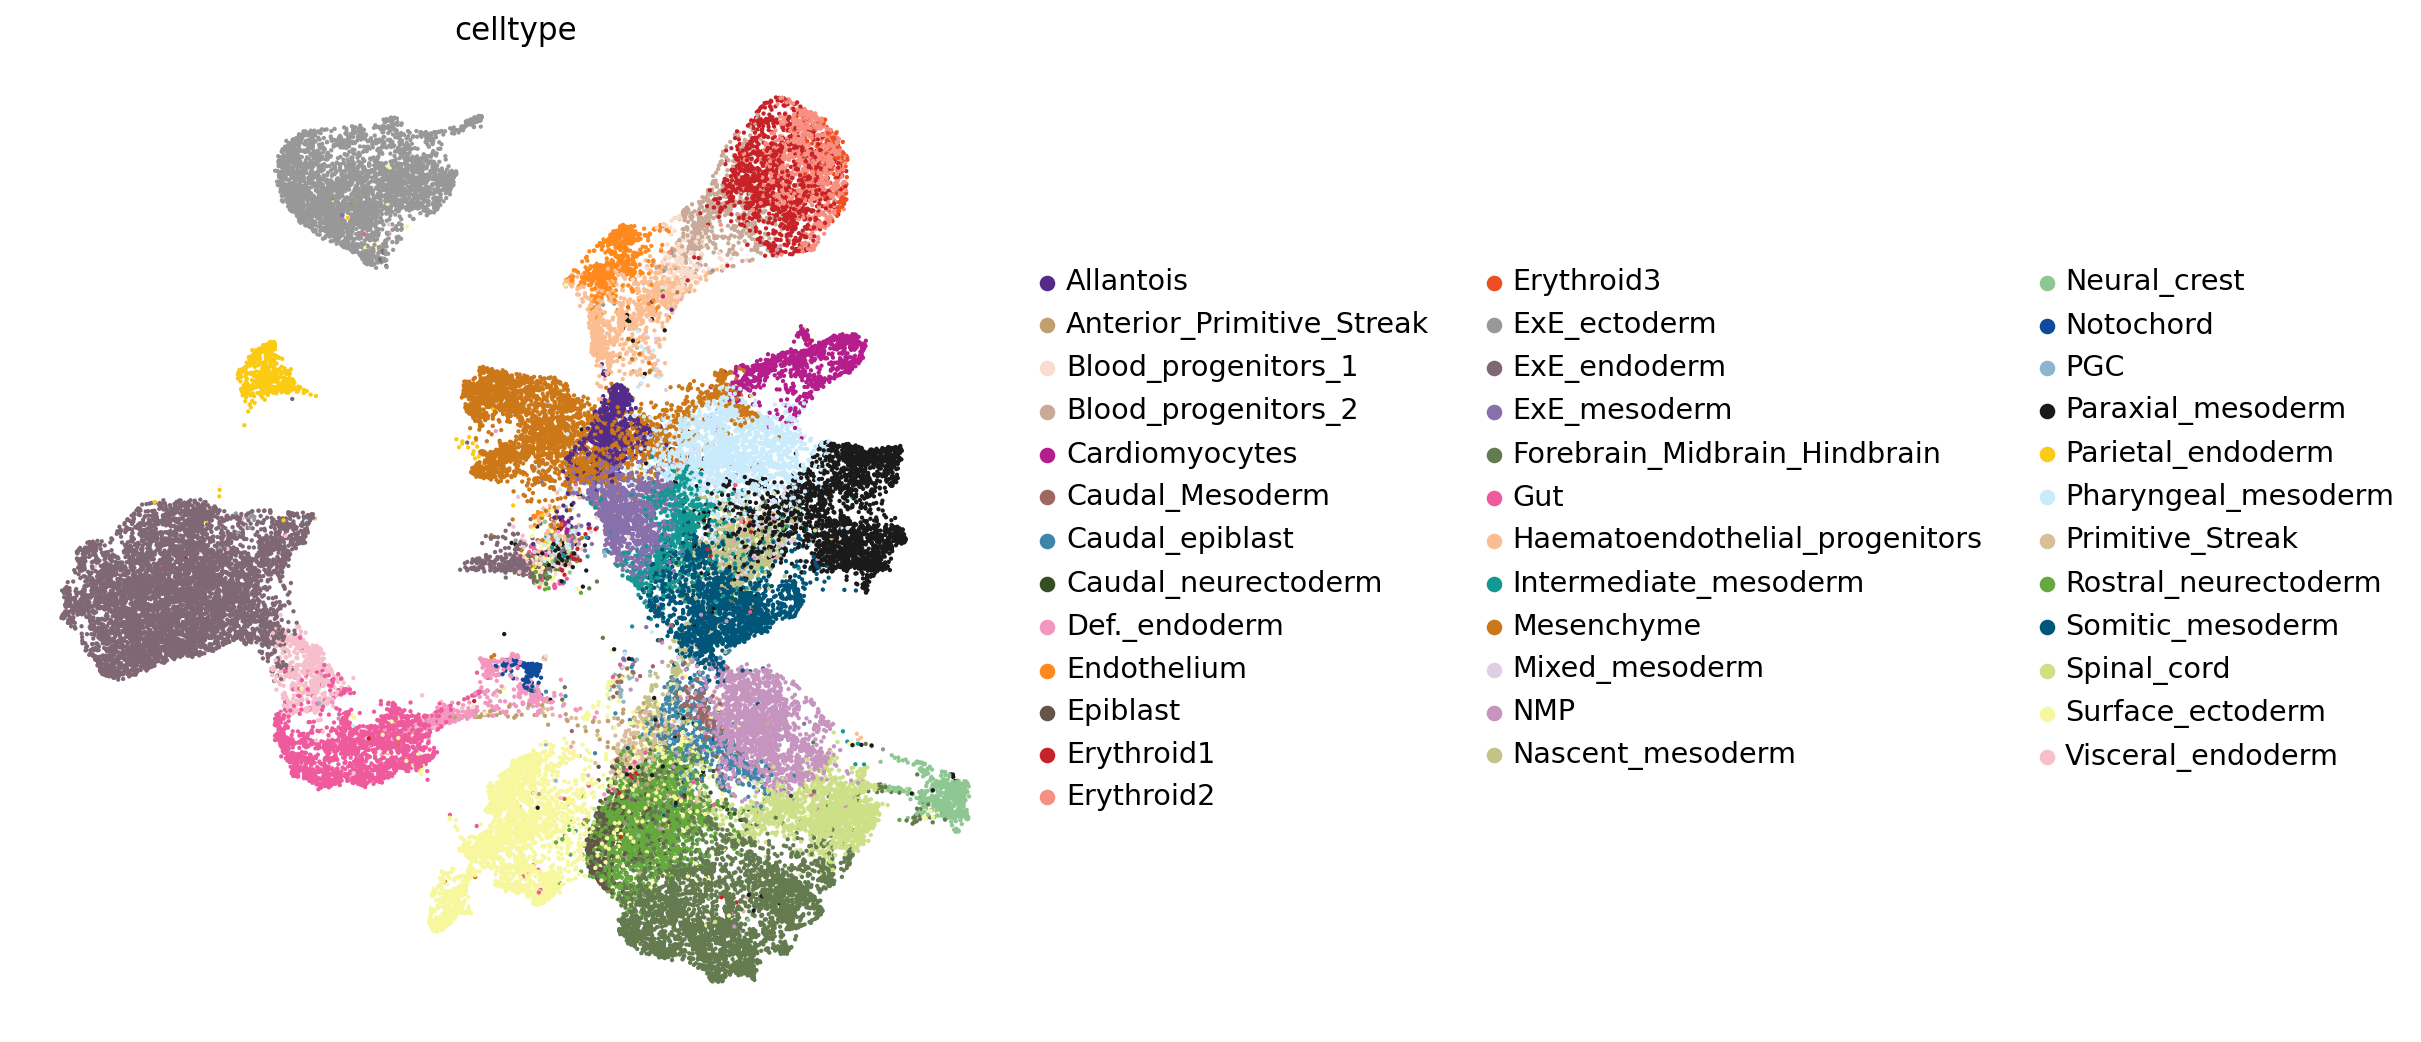

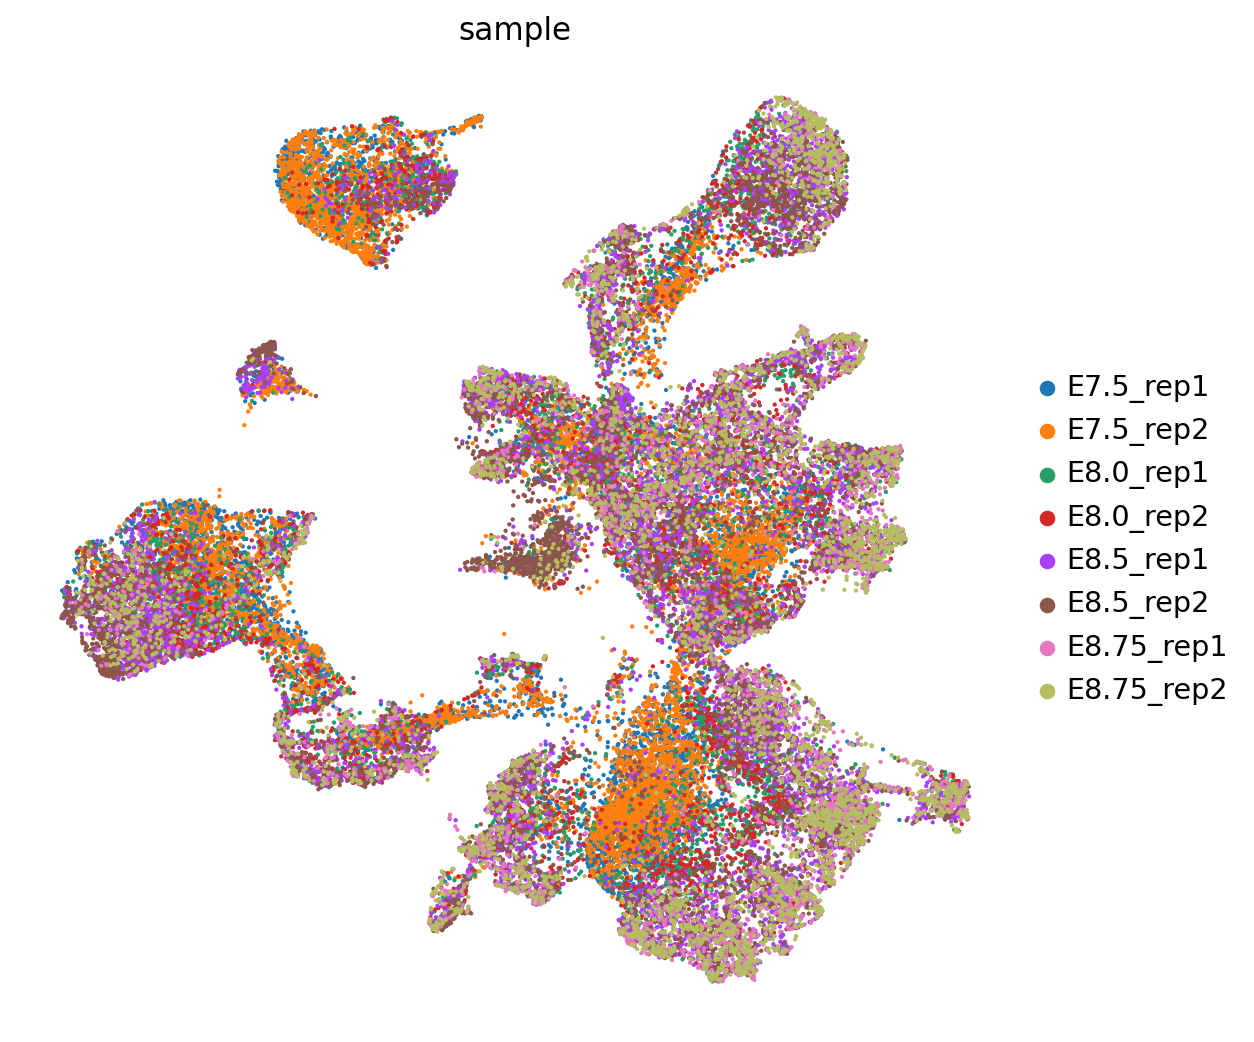

In [77]:
sc.pl.umap(
    adata,
    color=["celltype"],
    frameon=False,
    size=15
)
sc.pl.umap(
    adata,
    color=["sample"],
    ncols=2,
    frameon=False,
    size=15
)

## Have a look at the nearest neighbors embedding

In [37]:
adata.uns["neighbors"]

OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 15, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'use_rep': 'X_scVI'}}
With overloaded keys:
	['connectivities', 'distances'].

In [50]:
connections = adata.obsp["connectivities"]

In [54]:
connections = connections[0:500, 1:500].todense()